In [1]:
!pip install torch torchvision einops timm tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 46.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import List
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.register_buffer('embeddings', embeddings)

    def forward(self, t):
        return self.embeddings[t].unsqueeze(-1).unsqueeze(-1)

In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_prob: float):
        super().__init__()
        num_groups = min(32, in_channels) if in_channels >= 32 else in_channels

        self.relu = nn.ReLU()
        self.gnorm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.gnorm2 = nn.GroupNorm(num_groups if out_channels >= 32 else out_channels, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)

        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x, time_emb):
        if time_emb.shape[1] != x.shape[1]:
            time_emb = nn.Conv2d(time_emb.shape[1], x.shape[1], kernel_size=1).to(x.device)(time_emb)

        h = self.gnorm1(x + time_emb)
        h = self.relu(h)
        h = self.conv1(h)
        h = self.gnorm2(h)
        h = self.relu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.proj is not None:
            x = self.proj(x)
        return h + x

In [5]:
class UNET(nn.Module):
    def __init__(self, Channels=[64, 128, 256, 512, 512, 384], input_channels=1, output_channels=1, time_steps=1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.time_steps = time_steps

        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        self.time_emb = SinusoidalEmbeddings(time_steps, Channels[0])

        self.downs = nn.ModuleList()
        for i in range(self.num_layers//2):
            in_ch = Channels[i]
            out_ch = Channels[i+1]
            self.downs.append(ResBlock(in_ch, out_ch, 0.1))

        self.ups = nn.ModuleList()
        for i in range(self.num_layers//2, self.num_layers-1):
            in_ch = Channels[i]
            out_ch = Channels[i+1]
            self.ups.append(ResBlock(in_ch, out_ch, 0.1))

        self.final_conv = nn.Sequential(
            nn.Conv2d(Channels[-1], Channels[-1]//2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(Channels[-1]//2, output_channels, kernel_size=1)
        )

    def forward(self, x, t):
        x = self.shallow_conv(x)
        t_emb = self.time_emb(t)

        residuals = []
        h = x
        for down in self.downs:
            h = down(h, t_emb)
            residuals.append(h)

        for i, up in enumerate(self.ups):
            residual = residuals[self.num_layers//2 - i - 1]
            if residual.shape[1] != h.shape[1]:
                residual = nn.Conv2d(residual.shape[1], h.shape[1], kernel_size=1).to(h.device)(residual)
            h = up(h + residual, t_emb)

        return self.final_conv(h)

In [6]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps=1000):
        super().__init__()
        self.num_time_steps = num_time_steps
        beta = torch.linspace(1e-4, 0.02, num_time_steps, device=device)
        alpha = 1 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        self.register_buffer('beta', beta)
        self.register_buffer('alpha', alpha)
        self.register_buffer('alpha_bar', alpha_bar)

    def forward(self, t):
        # Ensure t is on the same device as beta and alpha_bar
        return self.beta[t], self.alpha_bar[t]

In [7]:
def sample(model, scheduler, num_samples=3, num_time_steps=1000, image_size=32):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 1, image_size, image_size).to(device)  # Generate noise
        for t in tqdm(reversed(range(num_time_steps)), desc="Sampling"):
            t_tensor = torch.tensor([t] * num_samples, device=device, dtype=torch.long)
            predicted_noise = model(x, t_tensor)

            beta, alpha_bar = scheduler(t_tensor)


            beta = beta.view(-1, 1, 1, 1)
            alpha_bar = alpha_bar.view(-1, 1, 1, 1)
            alpha = 1 - beta  # Compute alpha

            # Sample next timestep x
            noise = torch.randn_like(x) if t > 0 else 0  # No noise at final step
            x = (1 / torch.sqrt(alpha)) * (x - ((beta / torch.sqrt(1 - alpha_bar)) * predicted_noise)) + torch.sqrt(beta) * noise

    return x.clamp(0, 1)  # Ensure pixel values are between 0 and 1


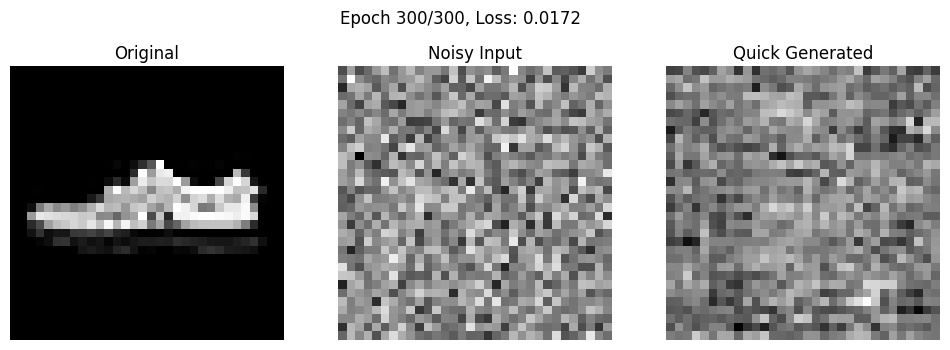

Training complete!
Model saved as ddpm_fashionmnist.pth


NameError: name 'scheduler' is not defined

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def train(batch_size=256, num_epochs=300, num_time_steps=1000, lr=2e-5):
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True,
                                   transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    model = UNET().to(device)
    scheduler = DDPM_Scheduler(num_time_steps).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (x, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            x = x.to(device)
            x = F.pad(x, (2,2,2,2))

            t = torch.randint(0, num_time_steps, (batch_size,), device=device, dtype=torch.long)
            noise = torch.randn_like(x)

            beta, alpha_bar = scheduler(t)
            alpha_bar = alpha_bar.view(-1, 1, 1, 1)  # Reshape to [batch_size, 1, 1, 1]
            noisy_x = torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise

            output = model(noisy_x, t)
            loss = criterion(output, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")


        if (epoch + 1) % 10 == 0 or (epoch + 1) == 20:
            with torch.no_grad():
                if (epoch + 1) == 20 or (epoch + 1) == 100:
                    print(f"Generating full samples for Epoch {epoch+1}...")
                    samples = sample(model, scheduler, num_samples=3)

                    clear_output(wait=True)
                    plt.figure(figsize=(12, 4))
                    for i in range(3):
                        plt.subplot(1, 3, i+1)
                        plt.imshow(samples[i].cpu().squeeze().numpy(), cmap='gray')
                        plt.title(f'Sample {i+1} (Epoch {epoch+1})')
                        plt.axis('off')
                    plt.suptitle(f'Full Samples After {epoch+1} Epochs, Loss: {avg_loss:.4f}')

                    plt.show()
                else:
                    print(f"Visualizing quick results for Epoch {epoch+1}")
                    sample_noise = torch.randn(1, 1, 32, 32).to(device)
                    sample_t = torch.tensor([num_time_steps-1], device=device, dtype=torch.long)
                    predicted_noise = model(sample_noise, sample_t)
                    _, alpha_bar = scheduler(sample_t)
                    alpha_bar = alpha_bar.view(-1, 1, 1, 1)
                    denoised = (sample_noise - torch.sqrt(1 - alpha_bar) * predicted_noise) / torch.sqrt(alpha_bar)

                    original = x[0].cpu().squeeze().numpy()
                    noisy = noisy_x[0].cpu().squeeze().numpy()
                    generated = denoised[0].cpu().squeeze().numpy()

                    clear_output(wait=True)
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.imshow(original, cmap='gray')
                    plt.title('Original')
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(noisy, cmap='gray')
                    plt.title('Noisy Input')
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(generated, cmap='gray')
                    plt.title('Quick Generated')
                    plt.axis('off')

                    plt.suptitle(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
                    plt.show()

    print("Training complete!")
    return model

if __name__ == "__main__":
    trained_model = train()
    # Now save the returned model
    torch.save(trained_model.state_dict(), 'ddpm_fashionmnist.pth')
    print("Model saved as ddpm_fashionmnist.pth")

   

Sampling: 1000it [00:06, 159.63it/s]


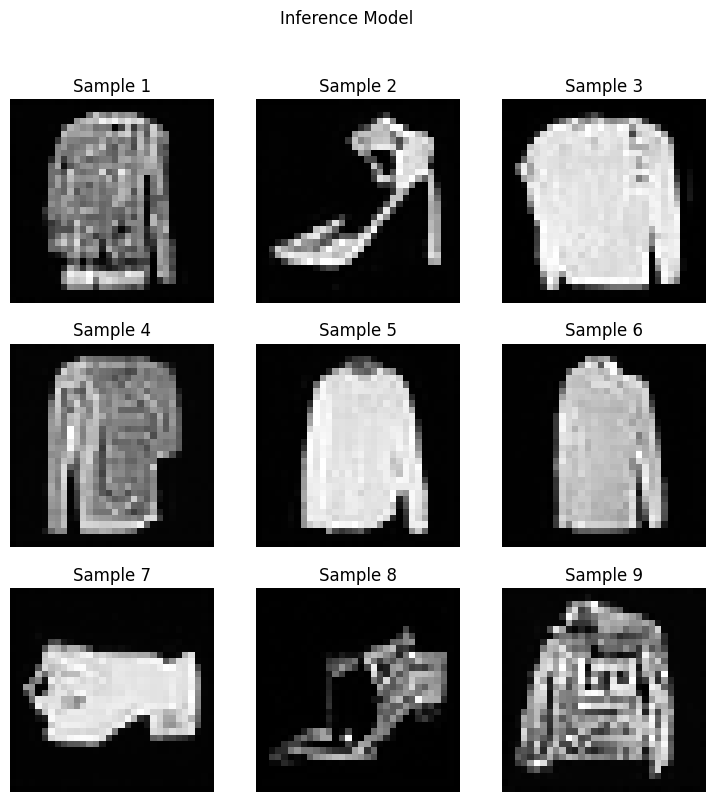

In [9]:
 # Load the model later for inference
model = UNET().to(device)
model.load_state_dict(torch.load('ddpm_fashionmnist.pth'))
model.eval()  # Set the model to evaluation mode for inference

# Re-instantiate the scheduler with the same num_time_steps used during training
scheduler = DDPM_Scheduler(num_time_steps=1000).to(device)

# Now generate samples
samples = sample(model, scheduler, num_samples=9)

plt.figure(figsize=(9, 9))  # Adjusted for a 3x3 grid
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(samples[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'Sample {i+1}')
    plt.axis('off')
plt.suptitle('Inference Model')
plt.show()